# Classifications (sentiment, emotion, hate) on dontpatronizeme dataset
## Histograms of the outputs of "*cardiffnlp/twitter-roberta-base*" models

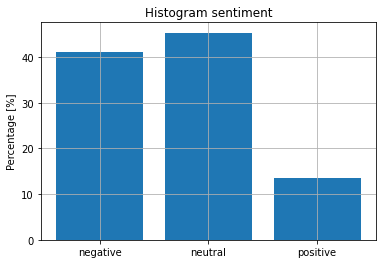

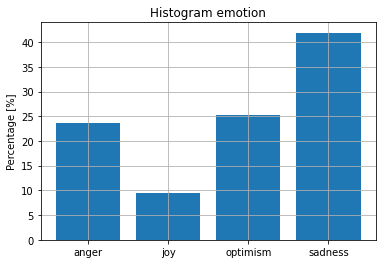

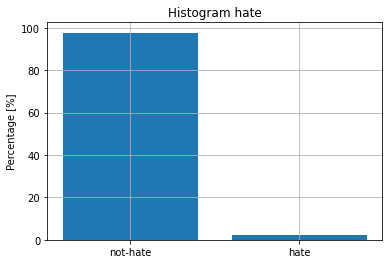

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import softmax

# Possible tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

tasks = ['sentiment', 'emotion', 'hate']

output = {
    'sentiment': np.load('./raw_outputs_sentiment.npy'),
    'emotion': np.load('./raw_outputs_emotion.npy'),
    'hate': np.load('./raw_outputs_hate.npy')
}

labels = {
    'sentiment': np.array(['negative', 'neutral', 'positive']),
    'emotion': np.array(['anger', 'joy', 'optimism', 'sadness']),
    'hate': np.array(['not-hate', 'hate'])
}

scores = {t: softmax(output[t], axis=1) for t in tasks}
pred_labels_idx = {t: np.argmax(scores[t], axis=1) for t in tasks}
pred_labels = {t: labels[t][pred_labels_idx[t]] for t in tasks}
hist_pred_labels = {t: [100*(pred_labels[t] == labels[t][i]).mean() 
                        for i in range(len(labels[t]))] for t in tasks}
for i,t in enumerate(tasks):
    plt.figure(i)
    plt.bar(labels[t], hist_pred_labels[t])
    plt.title(f'Histogram {t}')
    plt.ylabel('Percentage [%]')
    plt.grid()

## Code for generating the outputs

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
import numpy as np
import pandas as pd
import torch
import csv
import urllib.request

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task = 'sentiment' # or 'emotion', 'hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL) # Download tokenizer (approx 1 MB)

#model = AutoModelForSequenceClassification.from_pretrained(MODEL) # Download model (approx 500MB)
#model.save_pretrained(f'./nlp_models/cardiffnlp/twitter-roberta-base-{task}')
# Or, if already saved locally:
model = AutoModelForSequenceClassification.from_pretrained(
    f'./nlp_models/cardiffnlp/twitter-roberta-base-{task}')

# Get number of labels (output dim) for the corresponding task
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
n_labels = len(labels)

# Data, as list of strings, to be tokenized
data_pcl = pd.read_csv("./dontpatronizeme_pcl.tsv", sep="\t", skiprows=3,
                       names=['par_id','art_id','keyword','country_code','text','label'])
pred_texts = data_pcl['text'].tolist()
for i in range(len(pred_texts)):
    if type(pred_texts[i]) != str :
        print(i, pred_texts[i])
        pred_texts[i] = ''   
n_texts = len(pred_texts)
print('len(pred_texts) =', n_texts)

# Tokenized texts
tokenized_texts = tokenizer(pred_texts, padding=True, truncation=True,
                            max_length=514, return_tensors='pt')
print(tokenized_texts.keys())
print(tokenized_texts['input_ids'].shape, tokenized_texts['attention_mask'].shape)


def main(n_texts, size, nb_labels):
    # The data and outputs are divided into batches that are saved bit by bit
    # to avoid loosing everything if bug
    raw_outputs = np.zeros((0, nb_labels), dtype=np.float32)
    for i in range(0, n_predictions//size):
        print(f'ITERATION {i}/{n_predictions//size}')
        start, stop = i*size, (i+1)*size
        with torch.no_grad():
            output = model(tokenized_texts['input_ids'][start:stop],
                           tokenized_texts['attention_mask'][start:stop])
        raw_outputs = np.concatenate((raw_outputs, output[0].detach().numpy()))
        np.save(f'raw_outputs_{task}.npy', raw_outputs)
    # Last batch:
    start, stop = n_predictions//size, n_predictions//size + n_predictions%size
    with torch.no_grad():
        output = model(tokenized_texts['input_ids'][start:stop],
                       tokenized_texts['attention_mask'][start:stop])
    raw_outputs = np.concatenate((raw_outputs, output[0].detach().numpy()))
    np.save(f'raw_outputs_{task}.npy', raw_outputs)
    return raw_outputs

if __name__=='__main__':
    if torch.cuda.is_available():
        torch.cuda.device(0)
    main(n_texts, 64, nb_labels)

## Code for saving predictions in cvs file

In [2]:
import numpy as np
import pandas as pd
import csv
import urllib.request
from scipy.special import softmax

tasks = ['sentiment', 'emotion', 'hate']

output = {
    'sentiment': np.load('./raw_outputs_sentiment.npy'),
    'emotion': np.load('./raw_outputs_emotion.npy'),
    'hate': np.load('./raw_outputs_hate.npy')
}

labels = {}
for t in tasks:
    mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{t}/mapping.txt"
    with urllib.request.urlopen(mapping_link) as f:
        html = f.read().decode('utf-8').split("\n")
        csvreader = csv.reader(html, delimiter='\t')
    labels[t] = np.array([row[1] for row in csvreader if len(row) > 1])


scores = {t: softmax(output[t], axis=1) for t in tasks}
pred_labels_idx = {t: np.argmax(scores[t], axis=1) for t in tasks}
pred_labels = {t: labels[t][pred_labels_idx[t]] for t in tasks}

data_pcl = pd.read_csv("./dontpatronizeme_v1.4/dontpatronizeme_pcl.tsv", sep="\t", skiprows=3,
                       names=['par_id','art_id','keyword','country_code','text','label'])

df_dict = {}
df = {}

for t in tasks:
    df_dict[t] = {
        'par_id': data_pcl['par_id'].values,
        'predicted_label': pred_labels[t],
        'predicted_label_idx': pred_labels_idx[t],
    }
    for i,l in enumerate(labels[t]):
        df_dict[t][f'score_{l}'] = scores[t][:,i]
    df[t] = pd.DataFrame(df_dict[t])
    #df[t].to_csv(f'./predictions_{t}.csv') # Save in cvs file

In [3]:
df['sentiment'].head()

,par_id,predicted_label,predicted_label_idx,score_negative,score_neutral,score_positive
0,1,negative,0,0.702688,0.265323,0.031989
1,2,neutral,1,0.334626,0.534547,0.130827
2,3,negative,0,0.536271,0.438813,0.024916
3,4,neutral,1,0.035795,0.886947,0.077258
4,5,neutral,1,0.462149,0.504625,0.033227


In [4]:
df['emotion'].head()

,par_id,predicted_label,predicted_label_idx,score_anger,score_joy,score_optimism,score_sadness
0,1,sadness,3,0.127528,0.009856,0.115319,0.747297
1,2,sadness,3,0.114379,0.009661,0.275161,0.600799
2,3,anger,0,0.680171,0.014112,0.129400,0.176317
3,4,sadness,3,0.300541,0.129730,0.233273,0.336456
4,5,sadness,3,0.133691,0.047435,0.081333,0.737541


In [5]:
df['hate'].head()

,par_id,predicted_label,predicted_label_idx,score_not-hate,score_hate
0,1,not-hate,0,0.965968,0.034032
1,2,not-hate,0,0.885291,0.114709
2,3,not-hate,0,0.669775,0.330225
3,4,not-hate,0,0.975465,0.024535
4,5,not-hate,0,0.917692,0.082308
